# Procedural Generation of Networks
> __Purpose__: The goal of this notebook is to construct a way of 1) representing the activity of neural networks in terms of its baseline parameters (gating variables, voltages, synaptic couplings), and 2) finding a way to then compress that "graph" into an ODE that can be fed to odeint such that a solution to the given network can be found.

> Specifically, this NB will build on the code from NB 11 and attempt to generate a "skeleton network" such that the code from NB 11 is essentially refactored (everything is functionalized in order to provide the ability to iterate/loop arbitrarily for the number of neurons in the network).

## Questions:
1. How to decide how many loops to go through, or perhaps better yet how to decide when the value being read in is a voltage for a new major node vs an additional gating variable or minor parameter?
2. Is this a data structures questions? Seems like optimal organization for the data would solve most of the problems (ie if they are nested structures then I could just loop through them)

## 7/9 Meeting
- Hi Kai. One additional comment from our meeting today: I suggest you work backwards. That is, think about a function that outputs on ODE RHS given an exact specification of the parameters, polynomial forms, and so on, for a specified dynamical system. Then think about how to randomly generate this parameters. The key thing for you to focus on is how to represent the graph that I drew as an ODE.

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Functions From Previous NBs

In [2]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    Cm = 0.01 #uF/cm^2
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return (1/Cm)*applied_current

In [ ]:
def plot_vnmh(x,t,vertIndex=-1,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15

    #Trying to stop them overlapping:
    #fig, ax = plt.subplots(2,1) #--> fig overwrites so I am no longer working on the subplots
    #fig.tight_layout(h_pad=2)
    #fig.suptitle('Overall Title')
    
    #Extract variables from matrix
    if x.shape[1] == 4:
        V = x[:,0]
        n = x[:,1]
        m = x[:,2]
        h = x[:,3]
        
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V)
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n,label="n")
            plt.plot(t,m,label="m")
            plt.plot(t,h,label="h")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()
        
    elif x.shape[0] == 10:
        V1 = x[0]
        n1 = x[1]
        m1 = x[2]
        h1 = x[3]
        s1 = x[4]
        V2 = x[5]
        n2 = x[6]
        m2 = x[7]
        h2 = x[8]
        s2 = x[9]
            
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        plt.plot(t,V2,label="Neuron 2")
        if (vertIndex < 0):
            pass
        else:
            plt.axvline(x = vertIndex, color = 'r', label = 'Index Above Threshold')
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n1,label="n1")
            plt.plot(t,m1,label="m1")
            plt.plot(t,h1,label="h1")
            plt.plot(t,n2,label="n2")
            plt.plot(t,m2,label="m2")
            plt.plot(t,h2,label="h2")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()

## Refactoring of odes_sigmoid from NB 11

In [3]:
#Functions replacing non-functionalized calls in odes_sigmoid

def tau_func(V, mean):
    '''
    Function which returns the time constant for the associated variable
    Note that currently we are ignoring the "bump" in the true Tau functions and instead
    simply returning the mean.  The mean has been precalculated and will just be passed
    in and out for form's sake.
    
    In the future may switch to represent Tau functions as Gaussians (which they appear to be), but
    this would require extra parameters (i.e. instead of mean would need the center, width, and upwards bias)
    '''
    return mean


def inf_func(V, v0, sigma):
    '''
    "quasi-Steady-State" ie the x_inf values
    '''
    
    if v0==0 and sigma==0:
        x_inf = 0
    else:
        x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
    return x_inf 


def diffEQ_func(tau, x_inf, x):
    '''
    ie dndt, dmdt, dhdt
    Attempting to find a method for incorporating in dVdt
    '''
    if x_inf==0 and x==0:
        dxdt = 0
    else:
        #for the base equations is just
        dxdt = (1/tau)*(x_inf - x)
    return dxdt

In [30]:
def odes_sigmoid(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''

    ######### CONSTANTS #########
    
    #THIS CATEGORY PROBABLY ALL NEEDS TO CHANGE SINCE WE AREN'T NECESSARILY WORKING WITH THE SAME CHANNELS EACH TIME
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -57.99 #-49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    
    #conductances (S is Siemens)
    gbarK = 0.36 #mS/cm2
    gbarNa = 1.2 #mS/cm2
    gbarL = 0.003 #mS/cm2
    gL = (1/Cm)*gbarL
    #So really there should be other values here for the 4th and 5th gating variables should those get used
    #gbar?(4) = ___
    #gbar?(5) = ___
    #For the synaptic coupling: 
    ###### NOT SURE ABOUT THESE VALUES ######
    gbars1 = 20
    gbars2 = 20
    gbars3 = 20
    gbars4 = 20
    gbars5 = 20
    
    ######### DEFINITIONS #########
    
    #For synaptic coupling
    maxParams = 5 #Takes advantage of the fact that there will be a tau, v0, inf, etc. for each gating var
    #^ ie we can keep reusing this since there will be the same number of parameters necessary for each gating var
    numSC = 5 #Everything set to a default of 5 currently
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    
    x = np.array(x) #Convert the list input to a true array
    numNodes = 0; numParams = 0
    try:
        numNodes, numParams = x.shape
    except ValueError:
        print("network_params may be a 1D array")
    if numParams==0 and numNodes==0:
        numNodes = 1 #Since it is a 1D array
        numParams = 1+5*maxParams #This should be the case anyway...
    
    infs = np.zeros((numNodes,maxParams))
    taus = np.zeros((numNodes,maxParams))
    dxdts = np.zeros((numNodes,maxParams)) #Double check that this shape is correct
    
    ######### LOOPING #########
    
    for nodeTemp in range(numNodes):
        
        '''
        #This might actually not be necessary...
        #If the var itself is zero then that should take care of it, if the var is nonzero then the rest shouldn't be zero...
        isPresent = [0] * maxParams
        #^2*maxParams because we have 5 gating vars
        for param in range(maxParams):
            #ie if v0x, sigmax, tau_x all = 0, then we can assume that it does not appear in the equation
            #Note: don't need to check the x = 0 case, because then it will just be zero anyways
            #  ^ Also, it might be possible for x to actually = 0, so we don't want to discount that
            if x[nodeTemp,param+1+4*maxParams]==0 and x[nodeTemp,param+1+2*maxParams]==0 and x[nodeTemp,param+1+3*maxParams]==0:
                isPresent[param] = 0
            else:
                isPresent[param] = 1 #ie it does appear in some form
        '''
                
    #For now, defining every neuron the same, but can change the "n,m,h" values...
    gK = (1/Cm)*gbarK*(x[nodeTemp,1+maxParams]**4)
    gNa = (1/Cm)*gbarNa*(x[nodeTemp,2+maxParams]**3)*x[nodeTemp,3+maxParams]
    #Again, would need to add something for the 4th and 5th gating variables should they exist
    #...
    #Synaptic couplings: ie gbar * s
    gs1 = gbars1 * x[nodeTemp,1+4*maxParams]
    gs2 = gbars2 * x[nodeTemp,2+4*maxParams]
    gs3 = gbars3 * x[nodeTemp,3+4*maxParams]
    gs4 = gbars4 * x[nodeTemp,4+4*maxParams]
    gs5 = gbars5 * x[nodeTemp,5+4*maxParams]
    
    #WHERE DOES THIS GO?
    ###########################################################################################
    #s VARIABLE
    #....
    #Replace this with a sigmoid approx (?) later? ... This is currently a constant for inf and tau... not sigmoid
    tau_s = 30 #ms
    s_inf = 10.0/11.0 
    alpha_s1 = (V1>0)*(1/tau_s)
    alpha_s2 = (V2>0)*(1/tau_s)
    beta_s = 1/tau_s
    ds1dt = alpha_s1*(1-s1)-beta_s*s1 
    ds2dt = alpha_s2*(1-s2)-beta_s*s2 
    ###########################################################################################

    #Define the steady state (inf) values, and the time constants (tau)
    #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
    for param in range(maxParams):
        #inf(V, v0, sigma)
        infs[nodeTemp,param] = inf_func(x[nodeTemp,0], x[nodeTemp,1+maxParams], x[nodeTemp,1+2*maxParams]) # 1 / (1 + np.exp(-(V-V0n)/sign))
        #tau(V, mean)
        taus[nodeTemp,param] = tau_func(x[nodeTemp,0], x[nodeTemp,1+3*maxParams])
        
    #Define each ODE    
    #Note: maxParams+1 because we have 5 (maxParams) gating var equations, but also an additional equation for V
    for param in range(maxParams+1): 
        #Probably need a base case for dVdt...
        if param==0:
            #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
            dxdts[nodeTemp,param] = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0]) + ...
            #Would need to include the 4th and 5th gating variables somehow...
            gs1*(ES[0]-x[nodeTemp,0]) + gs2*(ES[1]-x[nodeTemp,0]) + gs3*(ES[2]-x[nodeTemp,0]) + ...
            gs4*(ES[3]-x[nodeTemp,0]) + gs5*(ES[4]-x[nodeTemp,0]) + ...
            #^ Terms: (conducance gs_x) * (ES - V)
            I(t,vI)
        else:
            #Note we use [nodeTemp,param] because @param=0, that is "n" var, NOT V var since there is no tau/inf for V
            dxdts[nodeTemp,param] = diffEQ_func(taus[nodeTemp,param], infs[nodeTemp,param], x[nodeTemp,1+param]) 
            #^Also double check that this doesn't break for the maxParams+1 case...
    
    #Rearrange dxdts into a list so that we can unpack it
    flat_array = dxdts.flatten()
    ODE_list = flat_array.tolist()
    
    #"*" indicates unpacking of list
    return ODE_list #*ODE_list doesn't work since it isn't fed into a function...

## Things to Recall about Synaptic Coupling

1. Technically, the synaptic coupling variable s goes to the other neuron...
    - So either need to find some way to connect neurons (i.e. actually tell which is connected to which...) or just "built this in" such that the s fed in through the parameters is the "correct" s (i.e. already "switched"...)
2. Had to turn off the current for neuron 2 in order to get oscillations...  How does this generalize to more than 2 neurons? Does only 1 recieve current?

dV1dt = (1/Cm) * (gNa1 * (ENa-V1) + gK1 * (EK-V1) + gL * (EL-V1) + gs2 * (ES2-V1) + I(t,vIscn)) <br/>
dV2dt = (1/Cm) * (gNa2 * (ENa-V2) + gK2 * (EK-V2) + gL * (EL-V2) + gs1 * (ES1-V2) + I(t,vIscn) * 0)

In [31]:
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

#V = x0[:,0]; n = x0[:,1]; m = x0[:,2]; h = x0[:,3]

V1 = -58; n1 = 0.05; m1 = 0.33; h1 = 0.6
#V0: Manipulates the x location placement
V0n1 = -49; V0m1 = -36; V0h1 = -55
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18; sigmam1 = 10; sigmah1 = -8
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810

node1 = [V1, n1, m1, h1, 0, 0, V0n1, V0m1, V0h1, 0, 0, 
 sigman1, sigmam1, sigmah1, 0, 0, tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0,
 0,0,0,0,0] #Synaptic couplings
node2 = [V1, n1, m1, h1, 0, 0, V0n1, V0m1, V0h1, 0, 0, 
 sigman1, sigmam1, sigmah1, 0, 0, tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0,
 0,0,0,0,0]

network_params = node1, node2

x = odeint(odes_sigmoid,network_params,t,args=(I,vI))


network_params may be a 1D array


IndexError: too many indices for array

In [35]:
node1 = [V1, n1, m1, h1, 0, 0, V0n1, V0m1, V0h1, 0, 0, 
 sigman1, sigmam1, sigmah1, 0, 0, tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0,
 0,0,0,0,0]

x = np.array(node1)
print(x.shape)

(26,)


Burn in run, looking for NO oscillations


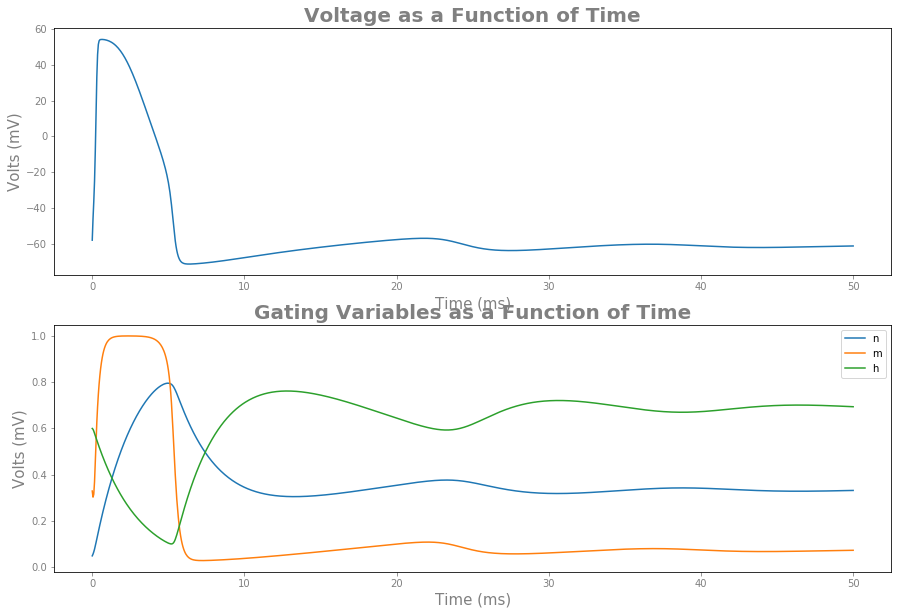

-----------------------------------------------------------------------------------
Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected


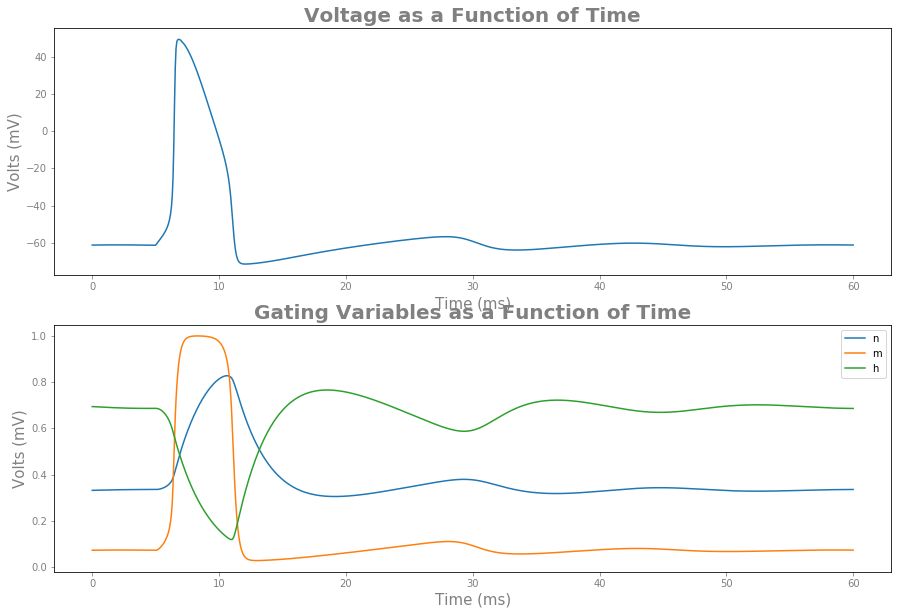

In [16]:
print("Burn in run, looking for NO oscillations")
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6]
#time vector
t = np.linspace(0,50,1000)
#vector needed 
vI = [0,0,0]

x = odeint(odes_sigmoid,x0,t,args=(I,vI))
plot_vnmh(x,t,gatingVars=True)

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]
x0_new = x[-1,:]
print("-----------------------------------------------------------------------------------")

print("Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
t = np.linspace(0,60,1000)
x = odeint(odes_sigmoid,x0_new,t,args=(I,vI))
V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]
plot_vnmh(x,t,gatingVars=True)
x0_2 = x[-1,:]